In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import sys
import json

sys.path.insert(0,'/home/garren/HPC Files/Pure RK PMF - No Temps')

from Post_procs import Post_process
import pandas as pd

In [2]:
functional_groups = np.array(['all'])
include_clusters = True
include_zeros = True
ARD = False
inf_type = 'MAP'

In [3]:
post_obj = Post_process(include_clusters=include_clusters,
                        include_zeros=include_zeros,
                        ARD=ARD,
                        inf_type=inf_type,
                        functional_groups=functional_groups)

In [4]:
A = post_obj.get_tensors()

In [5]:
Idx_known = post_obj.Idx_known
c_all = post_obj.c_all

In [6]:
data_dict = post_obj.get_reconstructed_values(A=A)

In [7]:
mix_all = np.char.add(np.char.add(data_dict['c1'], ' + '), data_dict['c2'])

In [8]:
mix_plot = np.array(['Methanoic acid + 1-Heptanol',
                     'n-Hexane + n-Heptane',
                     'Cyclohexane + Cyclooctane',
                     'Methanol + Ethanol',
                     'Cycloheptane + Ethanol',
                     'Aniline + Methanol'])
c1_plot = np.sum((np.array([m.split(' + ') for m in mix_plot])[:,0][:,np.newaxis] == c_all[np.newaxis,:])*np.arange(len(c_all))[np.newaxis,:], axis=1)
c2_plot = np.sum((np.array([m.split(' + ') for m in mix_plot])[:,1][:,np.newaxis] == c_all[np.newaxis,:])*np.arange(len(c_all))[np.newaxis,:], axis=1)
Idx_plot = np.stack((c1_plot, c2_plot), axis=1)

In [9]:
y_MC_interps = post_obj.extract_interps(A=A,Idx=Idx_plot)
ranks_idx = np.where(post_obj.ranks==9)[0][0]
y_MC_interps = y_MC_interps[ranks_idx,:,:]

In [10]:
x2_int = np.array(json.load(open(post_obj.data_file, 'r'))['x2_int'])
x_MC = x2_int
T_MC = 298.15*np.ones_like(x2_int)
jitter = json.load(open(post_obj.data_file, 'r'))['jitter']
v_MC = np.array(json.load(open(post_obj.data_file, 'r'))['v_MC'])

K_MC = post_obj.K(x_MC, x_MC, T_MC, T_MC) + (jitter+v_MC)*np.eye(x_MC.shape[0])
L_MC = np.linalg.cholesky(K_MC)
L_MC_inv = np.linalg.inv(L_MC)
K_MC_inv = L_MC_inv.T @ L_MC_inv
del K_MC, L_MC

mix_all = np.char.add(np.char.add(post_obj.c_all[Idx_plot[:,0]], ' + '), post_obj.c_all[Idx_plot[:,1]])
unique_mix, idx = np.unique(mix_all, return_index=True)
unique_mix = unique_mix[np.argsort(idx)]
df_UNIFAC = pd.read_excel(post_obj.excel_plots_known, sheet_name='Training_Plots')
UNIFAC_mix = np.char.add(np.char.add(df_UNIFAC['Component 1'].to_numpy().astype(str), ' + '), df_UNIFAC['Component 2'].to_numpy().astype(str))

exp_mix = np.char.add(np.char.add(data_dict['c1'], ' + '), data_dict['c2'])

In [11]:
matplotlib.use('qt5agg')
%matplotlib inline

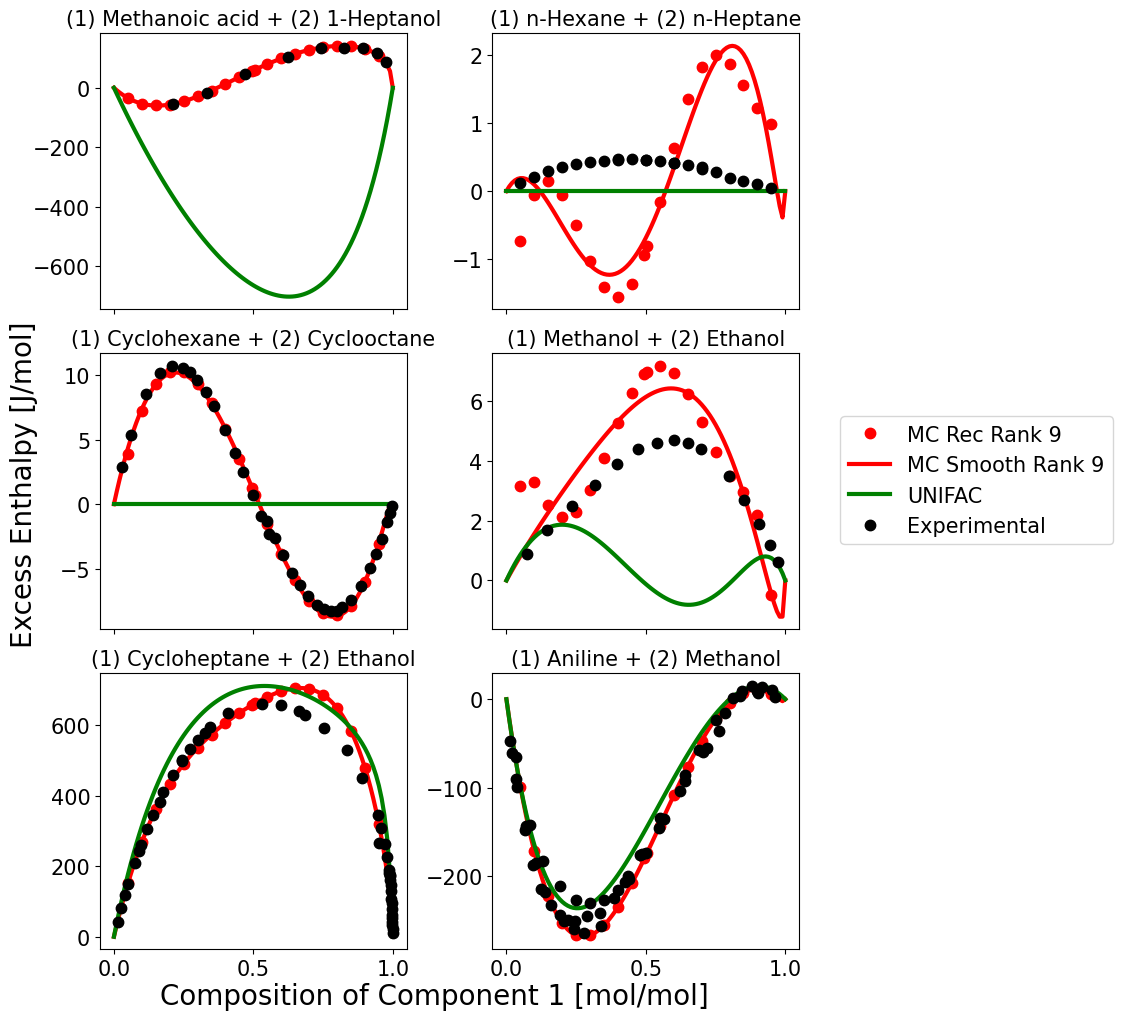

In [12]:
fig, ax = plt.subplots(3,2,figsize=(8,10),sharex=True)
ax = ax.flatten()

for i in range(len(unique_mix)):
    mix_idx_UNIFAC = UNIFAC_mix == unique_mix[i]
    TT_UNIFAC = df_UNIFAC['Temperature [K]'].to_numpy()[mix_idx_UNIFAC]
    T_idx_UNIFAC = np.abs(TT_UNIFAC - 298.15)<=0.5
    yy_UNIFAC = df_UNIFAC['UNIFAC_DMD [J/mol]'].to_numpy()[mix_idx_UNIFAC][T_idx_UNIFAC]
    xx_UNIFAC = df_UNIFAC['Composition component 1 [mol/mol]'].to_numpy()[mix_idx_UNIFAC][T_idx_UNIFAC]

    mix_idx_exp = exp_mix == unique_mix[i]
    TT_exp = np.abs(data_dict['T'][mix_idx_exp] - 298.15)<=0.5
    xx_exp = data_dict['x'][mix_idx_exp][TT_exp]
    yy_exp = data_dict['y_exp'][mix_idx_exp][TT_exp]

    K_plot_MC = post_obj.K(xx_UNIFAC, x_MC, 298.15*np.ones_like(xx_UNIFAC), T_MC)

    y_MC = K_plot_MC @ K_MC_inv @ y_MC_interps[:,i]

    p1 = ax[i].plot(x_MC, y_MC_interps[:,i], '.r', label='MC Rec Rank 9', markersize=15)
    p2 = ax[i].plot(xx_UNIFAC, y_MC, '-r', label='MC Smooth Rank 9', linewidth=3)
    p3 = ax[i].plot(xx_UNIFAC, yy_UNIFAC, '-g', label='UNIFAC', linewidth=3)
    p4 = ax[i].plot(xx_exp, yy_exp, '.k', label='Experimental', markersize=15)

    c1 = c_all[Idx_plot[i,0]]
    c2 = c_all[Idx_plot[i,1]]

    ax[i].set_title(f'(1) {c1} + (2) {c2}', fontsize=15)

for a in ax:
    a.tick_params(axis='both', which='major', labelsize=15)

plt.tight_layout()

plt.legend([p1[0], p2[0], p3[0], p4[0]], 
           ['MC Rec Rank 9', 'MC Smooth Rank 9', 'UNIFAC', 'Experimental'], 
           bbox_to_anchor=(1.1, 1.7), 
           loc='center left',
           fontsize=15)
fig.text(0.52, -0.01, 'Composition of Component 1 [mol/mol]', ha='center', fontsize=20)
fig.text(-0.01, 0.51, 'Excess Enthalpy [J/mol]', va='center', rotation='vertical', fontsize=20)

png_path = f'{post_obj.path}/9/2D Plots/Training_Plots.png'

fig.savefig(png_path, dpi=500, bbox_inches='tight')

In [13]:
data_dict = post_obj.get_testing_values(A=A)

In [14]:
mix_plot = np.array(['Methyl acetate + Methyl butyrate',
                     'Methyl acetate + Methyl pentanoate'])
c1_plot = np.sum((np.array([m.split(' + ') for m in mix_plot])[:,0][:,np.newaxis] == c_all[np.newaxis,:])*np.arange(len(c_all))[np.newaxis,:], axis=1)
c2_plot = np.sum((np.array([m.split(' + ') for m in mix_plot])[:,1][:,np.newaxis] == c_all[np.newaxis,:])*np.arange(len(c_all))[np.newaxis,:], axis=1)
Idx_plot = np.stack((c1_plot, c2_plot), axis=1)

In [15]:
y_MC_interps = post_obj.extract_interps(A=A,Idx=Idx_plot)
ranks_idx = np.where(post_obj.ranks==9)[0][0]
y_MC_interps = y_MC_interps[ranks_idx,:,:]

In [16]:
mix_all = np.char.add(np.char.add(post_obj.c_all[Idx_plot[:,0]], ' + '), post_obj.c_all[Idx_plot[:,1]])
unique_mix, idx = np.unique(mix_all, return_index=True)
unique_mix = unique_mix[np.argsort(idx)]
df_UNIFAC = pd.read_excel(post_obj.excel_plots_known, sheet_name='Testing_Plots')
UNIFAC_mix = np.char.add(np.char.add(df_UNIFAC['Component 1'].to_numpy().astype(str), ' + '), df_UNIFAC['Component 2'].to_numpy().astype(str))

exp_mix = np.char.add(np.char.add(data_dict['c1'], ' + '), data_dict['c2'])

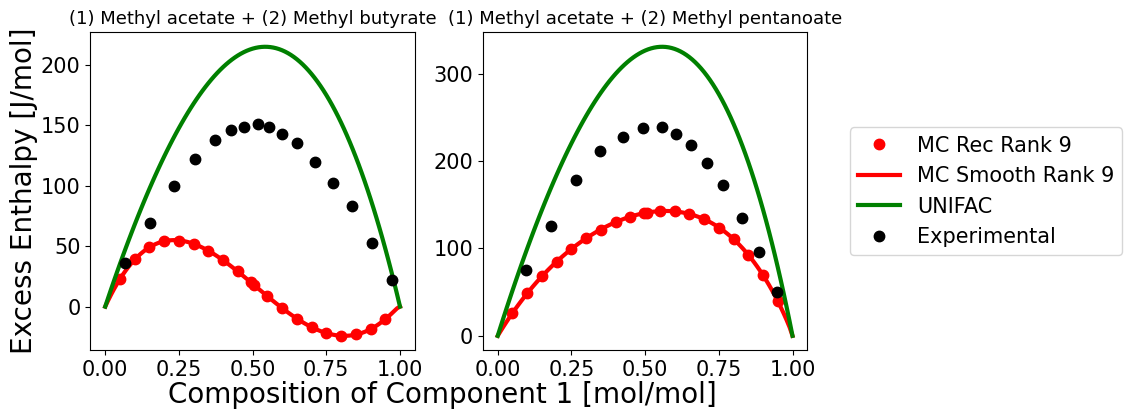

In [17]:
fig, ax = plt.subplots(1,2,figsize=(8,4),sharex=True)
ax = ax.flatten()

for i in range(len(unique_mix)):
    mix_idx_UNIFAC = UNIFAC_mix == unique_mix[i]
    TT_UNIFAC = df_UNIFAC['Temperature [K]'].to_numpy()[mix_idx_UNIFAC]
    T_idx_UNIFAC = np.abs(TT_UNIFAC - 298.15)<=0.5
    yy_UNIFAC = df_UNIFAC['UNIFAC_DMD [J/mol]'].to_numpy()[mix_idx_UNIFAC][T_idx_UNIFAC]
    xx_UNIFAC = df_UNIFAC['Composition component 1 [mol/mol]'].to_numpy()[mix_idx_UNIFAC][T_idx_UNIFAC]

    mix_idx_exp = exp_mix == unique_mix[i]
    TT_exp = np.abs(data_dict['T'][mix_idx_exp] - 298.15)<=0.5
    xx_exp = data_dict['x'][mix_idx_exp][TT_exp]
    yy_exp = data_dict['y_exp'][mix_idx_exp][TT_exp]

    K_plot_MC = post_obj.K(xx_UNIFAC, x_MC, 298.15*np.ones_like(xx_UNIFAC), T_MC)

    y_MC = K_plot_MC @ K_MC_inv @ y_MC_interps[:,i]

    p1 = ax[i].plot(x_MC, y_MC_interps[:,i], '.r', label='MC Rec Rank 9', markersize=15)
    p2 = ax[i].plot(xx_UNIFAC, y_MC, '-r', label='MC Smooth Rank 9', linewidth=3)
    p3 = ax[i].plot(xx_UNIFAC, yy_UNIFAC, '-g', label='UNIFAC', linewidth=3)
    p4 = ax[i].plot(xx_exp, yy_exp, '.k', label='Experimental', markersize=15)

    c1 = c_all[Idx_plot[i,0]]
    c2 = c_all[Idx_plot[i,1]]

    ax[i].set_title(f'(1) {c1} + (2) {c2}', fontsize=13)

for a in ax:
    a.tick_params(axis='both', which='major', labelsize=15)

plt.tight_layout()

plt.legend([p1[0], p2[0], p3[0], p4[0]], 
           ['MC Rec Rank 9', 'MC Smooth Rank 9', 'UNIFAC', 'Experimental'], 
           bbox_to_anchor=(1.1, 0.5), 
           loc='center left',
           fontsize=15)
fig.text(0.52, -0.02, 'Composition of Component 1 [mol/mol]', ha='center', fontsize=20)
fig.text(-0.02, 0.51, 'Excess Enthalpy [J/mol]', va='center', rotation='vertical', fontsize=20)

png_path = f'{post_obj.path}/9/2D Plots/Ester1_Ester1.png'

fig.savefig(png_path, dpi=500, bbox_inches='tight')

In [18]:
mix_plot = np.array(['Propanone + Butanone',
                     'Propanone + 2-Pentanone',
                     '2-Pentanone + 2-Octanone',
                     'Butanone + 2-Octanone'])
c1_plot = np.sum((np.array([m.split(' + ') for m in mix_plot])[:,0][:,np.newaxis] == c_all[np.newaxis,:])*np.arange(len(c_all))[np.newaxis,:], axis=1)
c2_plot = np.sum((np.array([m.split(' + ') for m in mix_plot])[:,1][:,np.newaxis] == c_all[np.newaxis,:])*np.arange(len(c_all))[np.newaxis,:], axis=1)
Idx_plot = np.stack((c1_plot, c2_plot), axis=1)

In [19]:
y_MC_interps = post_obj.extract_interps(A=A,Idx=Idx_plot)
ranks_idx = np.where(post_obj.ranks==9)[0][0]
y_MC_interps = y_MC_interps[ranks_idx,:,:]

In [20]:
mix_all = np.char.add(np.char.add(post_obj.c_all[Idx_plot[:,0]], ' + '), post_obj.c_all[Idx_plot[:,1]])
unique_mix, idx = np.unique(mix_all, return_index=True)
unique_mix = unique_mix[np.argsort(idx)]

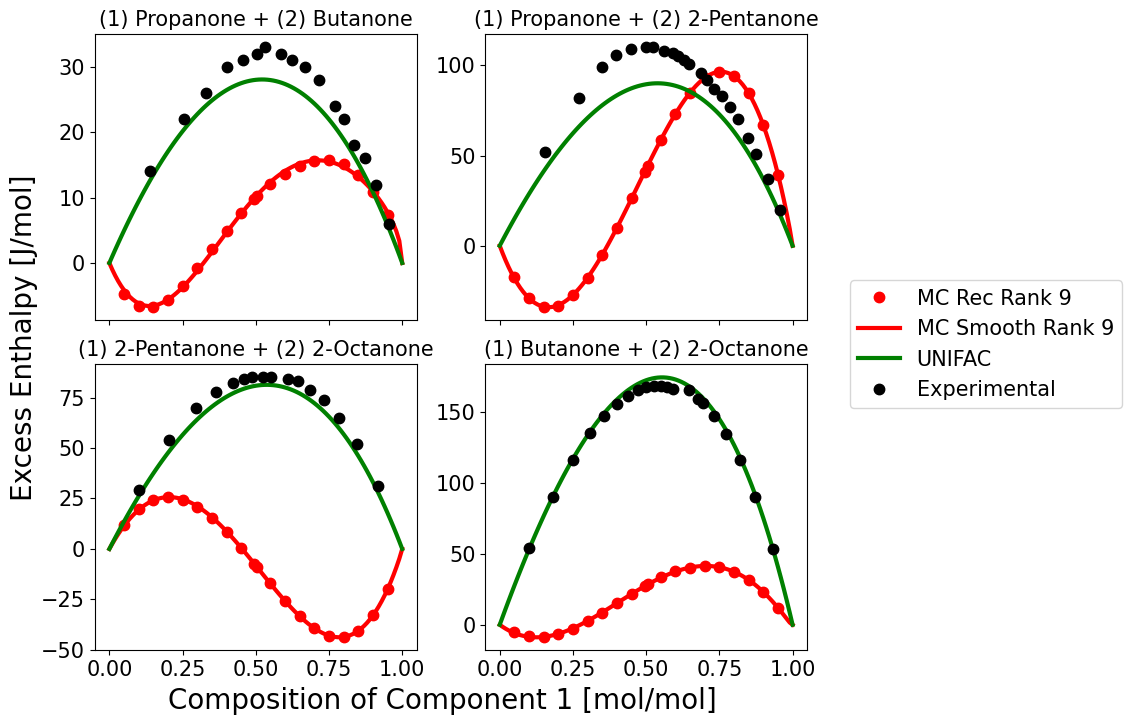

In [21]:
fig, ax = plt.subplots(2,2,figsize=(8,7),sharex=True)
ax = ax.flatten()

for i in range(len(unique_mix)):
    mix_idx_UNIFAC = UNIFAC_mix == unique_mix[i]
    TT_UNIFAC = df_UNIFAC['Temperature [K]'].to_numpy()[mix_idx_UNIFAC]
    T_idx_UNIFAC = np.abs(TT_UNIFAC - 298.15)<=0.5
    yy_UNIFAC = df_UNIFAC['UNIFAC_DMD [J/mol]'].to_numpy()[mix_idx_UNIFAC][T_idx_UNIFAC]
    xx_UNIFAC = df_UNIFAC['Composition component 1 [mol/mol]'].to_numpy()[mix_idx_UNIFAC][T_idx_UNIFAC]

    mix_idx_exp = exp_mix == unique_mix[i]
    TT_exp = np.abs(data_dict['T'][mix_idx_exp] - 298.15)<=0.5
    xx_exp = data_dict['x'][mix_idx_exp][TT_exp]
    yy_exp = data_dict['y_exp'][mix_idx_exp][TT_exp]

    K_plot_MC = post_obj.K(xx_UNIFAC, x_MC, 298.15*np.ones_like(xx_UNIFAC), T_MC)

    y_MC = K_plot_MC @ K_MC_inv @ y_MC_interps[:,i]

    p1 = ax[i].plot(x_MC, y_MC_interps[:,i], '.r', label='MC Rec Rank 9', markersize=15)
    p2 = ax[i].plot(xx_UNIFAC, y_MC, '-r', label='MC Smooth Rank 9', linewidth=3)
    p3 = ax[i].plot(xx_UNIFAC, yy_UNIFAC, '-g', label='UNIFAC', linewidth=3)
    p4 = ax[i].plot(xx_exp, yy_exp, '.k', label='Experimental', markersize=15)

    c1 = c_all[Idx_plot[i,0]]
    c2 = c_all[Idx_plot[i,1]]

    ax[i].set_title(f'(1) {c1} + (2) {c2}', fontsize=15)

for a in ax:
    a.tick_params(axis='both', which='major', labelsize=15)

plt.tight_layout()

plt.legend([p1[0], p2[0], p3[0], p4[0]], 
           ['MC Rec Rank 9', 'MC Smooth Rank 9', 'UNIFAC', 'Experimental'], 
           bbox_to_anchor=(1.1, 1.07), 
           loc='center left',
           fontsize=15)
fig.text(0.52, -0.02, 'Composition of Component 1 [mol/mol]', ha='center', fontsize=20)
fig.text(-0.02, 0.51, 'Excess Enthalpy [J/mol]', va='center', rotation='vertical', fontsize=20)

png_path = f'{post_obj.path}/9/2D Plots/Ketone2_Ketone2.png'

fig.savefig(png_path, dpi=500, bbox_inches='tight')

In [22]:
mix_plot = np.array(['Methnoic acid + Ethanoic acid',
                     'Ethanoic acid + Propanoic acid',])
c1_plot = np.sum((np.array([m.split(' + ') for m in mix_plot])[:,0][:,np.newaxis] == c_all[np.newaxis,:])*np.arange(len(c_all))[np.newaxis,:], axis=1)
c2_plot = np.sum((np.array([m.split(' + ') for m in mix_plot])[:,1][:,np.newaxis] == c_all[np.newaxis,:])*np.arange(len(c_all))[np.newaxis,:], axis=1)
Idx_plot = np.stack((c1_plot, c2_plot), axis=1)

In [23]:
y_MC_interps = post_obj.extract_interps(A=A,Idx=Idx_plot)
ranks_idx = np.where(post_obj.ranks==9)[0][0]
y_MC_interps = y_MC_interps[ranks_idx,:,:]

In [24]:
mix_all = np.char.add(np.char.add(post_obj.c_all[Idx_plot[:,0]], ' + '), post_obj.c_all[Idx_plot[:,1]])
unique_mix, idx = np.unique(mix_all, return_index=True)
unique_mix = unique_mix[np.argsort(idx)]

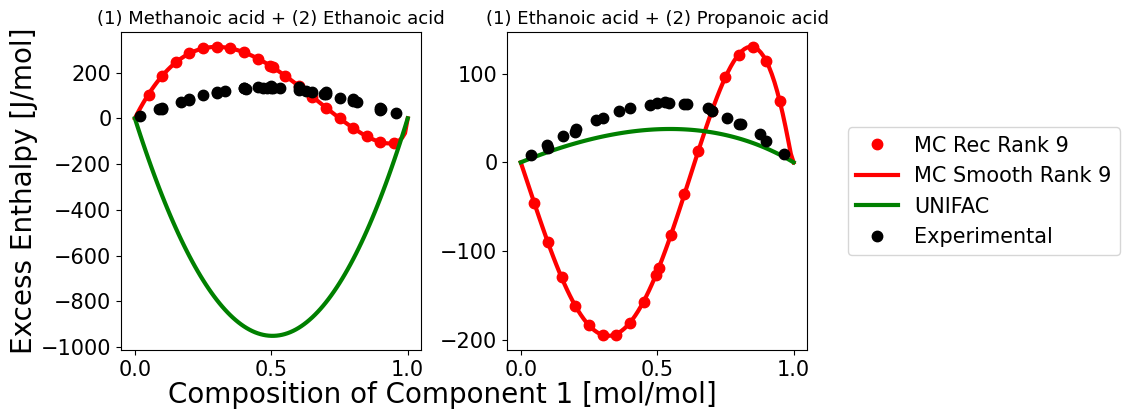

In [25]:
fig, ax = plt.subplots(1,2,figsize=(8,4),sharex=True)
ax = ax.flatten()

for i in range(len(unique_mix)):
    mix_idx_UNIFAC = UNIFAC_mix == unique_mix[i]
    TT_UNIFAC = df_UNIFAC['Temperature [K]'].to_numpy()[mix_idx_UNIFAC]
    T_idx_UNIFAC = np.abs(TT_UNIFAC - 298.15)<=0.5
    yy_UNIFAC = df_UNIFAC['UNIFAC_DMD [J/mol]'].to_numpy()[mix_idx_UNIFAC][T_idx_UNIFAC]
    xx_UNIFAC = df_UNIFAC['Composition component 1 [mol/mol]'].to_numpy()[mix_idx_UNIFAC][T_idx_UNIFAC]

    mix_idx_exp = exp_mix == unique_mix[i]
    TT_exp = np.abs(data_dict['T'][mix_idx_exp] - 298.15)<=0.5
    xx_exp = data_dict['x'][mix_idx_exp][TT_exp]
    yy_exp = data_dict['y_exp'][mix_idx_exp][TT_exp]

    K_plot_MC = post_obj.K(xx_UNIFAC, x_MC, 298.15*np.ones_like(xx_UNIFAC), T_MC)

    y_MC = K_plot_MC @ K_MC_inv @ y_MC_interps[:,i]

    p1 = ax[i].plot(x_MC, y_MC_interps[:,i], '.r', label='MC Rec Rank 9', markersize=15)
    p2 = ax[i].plot(xx_UNIFAC, y_MC, '-r', label='MC Smooth Rank 9', linewidth=3)
    p3 = ax[i].plot(xx_UNIFAC, yy_UNIFAC, '-g', label='UNIFAC', linewidth=3)
    p4 = ax[i].plot(xx_exp, yy_exp, '.k', label='Experimental', markersize=15)

    c1 = c_all[Idx_plot[i,0]]
    c2 = c_all[Idx_plot[i,1]]

    ax[i].set_title(f'(1) {c1} + (2) {c2}', fontsize=13)

for a in ax:
    a.tick_params(axis='both', which='major', labelsize=15)

plt.tight_layout()

plt.legend([p1[0], p2[0], p3[0], p4[0]], 
           ['MC Rec Rank 9', 'MC Smooth Rank 9', 'UNIFAC', 'Experimental'], 
           bbox_to_anchor=(1.1, 0.5), 
           loc='center left',
           fontsize=15)
fig.text(0.52, -0.02, 'Composition of Component 1 [mol/mol]', ha='center', fontsize=20)
fig.text(-0.02, 0.51, 'Excess Enthalpy [J/mol]', va='center', rotation='vertical', fontsize=20)

png_path = f'{post_obj.path}/9/2D Plots/Acid_Acid.png'

fig.savefig(png_path, dpi=500, bbox_inches='tight')